# load and process USDA data

## price data

In [102]:
food_simplification = {
    "Broccoli florets": "Broccoli",
    "Broccoli heads": "Broccoli",
    "Carrots, cooked whole": "Carrots",
    "Carrots, raw whole": "Carrots",
    "Cauliflower florets": "Cauliflower",
    "Cauliflower heads": "Cauliflower",
    "Celery, trimmed bunches": "Celery",
    "Celery sticks": "Celery",
    "Collard greens": "Collard",
    "Carrots, baby": "Carrots",
    "Cucumbers with peel": "Cucumber",
    "Cucumbers without peel": "Cucumber",
    "Lettuce, romaine, heads": "Lettuce",
    "Lettuce, romaine, hearts": "Lettuce",
    "Mushrooms, whole": "Mushrooms",
    "Mushrooms, sliced": "Mushrooms",
    "Spinach, boiled": "Spinach",
    "Spinach, eaten raw": "Spinach",
    "Tomatoes, grape & cherry": "Tomatoes",
    "Tomatoes, roma & plum": "Tomatoes",
    "Tomatoes, large round": "Tomatoes",
    "Berries, mixed": "Berries",
    "Grapes (raisins)": "Grapes",
    "Mangoes": "Mango",
    "Plum (prunes)": "Plum"
}

In [103]:
from pandas import read_csv, read_excel, concat
from json import dump

prices = concat([read_csv("Vegetable-Prices-2022.csv").rename(columns={"Vegetable": "Food"}),
                 read_csv("Fruit-Prices-2022.csv").rename(columns={"Fruit": "Food"})]).set_index("Food")
display(prices)
print(prices["CupEquivalentUnit"].unique())
prices = prices[prices["Form"] != "Canned"]
prices = prices[prices["CupEquivalentUnit"] == "pounds"]
prices.index = [food_simplification.get(i,i) for i in prices.index]
prices.drop(columns=["Form", "RetailPriceUnit", "CupEquivalentUnit"], inplace=True)
prices.drop(["Potatoes, french fries", "Dates"]+[i for i in prices.index if "Mixed" in i], inplace=True)
prices = prices.groupby(level=0).mean()
display(prices)

# 1 Cup = 0.236 L
## TODO convert this into per 100 grams to match the nutritional data
food_info = {}
for food, row in prices.iterrows():
    food_info[food] = {
        "price": row["RetailPrice"],
        "cupEQ": row["CupEquivalentSize"],
        "yield": row["Yield"],
    }

food_info.update({
    "Flax seeds": {
        "price": 3.86,  # sourced from Amazon
        "cupEQ": 0.37,   # sourced from https://www.aqua-calc.com/page/density-table/substance/seeds-coma-and-blank-flaxseed-blank--op-tbsp-coma-and-blank-whole-cp-
        "yield": 1  # all of flaxseeds are eaten
    }
})

with open("food_info.json", 'w') as jsonOut:
    dump(food_info, jsonOut, indent=3)

,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice
Food,,,,,,,
Acorn squash,Fresh,1.2136,per pound,0.4586,0.4519,pounds,1.1961
Artichoke,Fresh,2.4703,per pound,0.3750,0.3858,pounds,2.5415
Artichoke,Canned,3.4498,per pound,0.6500,0.3858,pounds,2.0476
Asparagus,Fresh,2.9531,per pound,0.4938,0.3968,pounds,2.3731
Asparagus,Canned,3.4328,per pound,0.6500,0.3968,pounds,2.0958
...,...,...,...,...,...,...,...
Raspberries,Fresh,7.7338,per pound,0.9600,0.3197,pounds,2.5753
Raspberries,Frozen,6.1590,per pound,1.0000,0.3307,pounds,2.0368
Strawberries,Fresh,2.9682,per pound,0.9400,0.3197,pounds,1.0094


['pounds' 'fluid ounces']


,RetailPrice,Yield,CupEquivalentSize,CupEquivalentPrice
Acorn squash,1.21360,0.45860,0.45190,1.196100
Apples,1.85410,0.90000,0.24250,0.499600
Apricots,5.63865,0.96500,0.25355,1.256150
Artichoke,2.47030,0.37500,0.38580,2.541500
Asparagus,4.88715,0.76365,0.39680,2.496100
...,...,...,...,...
Sweet potatoes,1.15650,0.88180,0.44090,0.578200
Tomatoes,2.43500,0.91000,0.37480,1.002833
Turnip greens,2.72095,0.76300,0.33620,1.195350
Watermelon,0.38200,0.52000,0.33070,0.242900


## nutritional data

In [29]:
# create mappings
## nutrient IDs -> nutrient names
# nutrients = read_csv("FoodData_Central_csv_2024-10-31/sub_sample_result.csv").set_index("food_nutrient_id")
# nutrient_names = dict(zip(nutrients.index.to_list(), nutrients["nutrient_name"].to_list()))
nutrients = read_csv("nutrient.csv").set_index("id")
nutrient_names = {}
for ID, row in nutrients.iterrows():
    nutrient_names[ID] = {"name": row["name"], "unit": row["unit_name"]}
display(nutrient_names)
# food IDs -> food names
food_metadata = read_csv("food.csv").set_index("fdc_id")
food_names = dict(zip(food_metadata.index.to_list(), food_metadata["description"].to_list()))

{2047: {'name': 'Energy (Atwater General Factors)', 'unit': 'KCAL'},
 2048: {'name': 'Energy (Atwater Specific Factors)', 'unit': 'KCAL'},
 1001: {'name': 'Solids', 'unit': 'G'},
 1002: {'name': 'Nitrogen', 'unit': 'G'},
 1003: {'name': 'Protein', 'unit': 'G'},
 1004: {'name': 'Total lipid (fat)', 'unit': 'G'},
 1005: {'name': 'Carbohydrate, by difference', 'unit': 'G'},
 1006: {'name': 'Fiber, crude (DO NOT USE - Archived)', 'unit': 'G'},
 1007: {'name': 'Ash', 'unit': 'G'},
 1008: {'name': 'Energy', 'unit': 'KCAL'},
 1009: {'name': 'Starch', 'unit': 'G'},
 1010: {'name': 'Sucrose', 'unit': 'G'},
 1011: {'name': 'Glucose', 'unit': 'G'},
 1012: {'name': 'Fructose', 'unit': 'G'},
 1013: {'name': 'Lactose', 'unit': 'G'},
 1014: {'name': 'Maltose', 'unit': 'G'},
 1015: {'name': 'Amylose', 'unit': 'G'},
 1016: {'name': 'Amylopectin', 'unit': 'G'},
 1017: {'name': 'Pectin', 'unit': 'G'},
 1018: {'name': 'Alcohol, ethyl', 'unit': 'G'},
 1019: {'name': 'Pentosan', 'unit': 'G'},
 1020: {'name'

In [ ]:
# inconsistent category codes are used between these files


# all_foods = read_csv("../food.csv").set_index("fdc_id")
# categories = read_csv("food_category.csv")#.set_index("")

In [ ]:
# nutrients = read_csv("FoodData_Central_csv_2024-10-31/fndds_ingredient_nutrient_value.csv").set_index("ingredient code")
foods = read_csv("../food_nutrient.csv").set_index("fdc_id")
foods = foods[foods["amount"] > 0]
display(foods)

foods_json = {}
for fdc, row in foods.iterrows():
    if fdc not in foods_json:
        foods_json[fdc] = {
            "name": food_names[fdc],
            "nutrients": {nutrient_names[row["nutrient_id"]]["name"]: row["amount"]}
        }
    else:    foods_json[fdc]["nutrients"].update({nutrient_names[row["nutrient_id"]]["name"]: row["amount"]})

In [26]:
foods

,id,nutrient_id,amount,data_points,derivation_id,min,max,median,loq,footnote,min_year_acquired,percent_daily_value
fdc_id,,,,,,,,,,,,
1105904,13706930,1293,53.33,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1105904,13706916,1008,867.00,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1105904,13706928,1258,13.33,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0
1105904,13706929,1292,20.00,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1105904,13706914,1004,93.33,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2721948,34555377,1005,17.86,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2721948,34555389,1253,107.00,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0
2721948,34555392,1292,14.29,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from json import dump
with open("../food_nutrients.json", 'w') as jsonOut:
    dump(foods_json, jsonOut, indent=3)

In [54]:
# only examine fresh (raw) foods, since this is the scope of this project
from json import load, dump
with open("../food_nutrients.json", 'r') as jsonIn:
    foods_json = load(jsonIn)

fresh_foods_json = {}
for ID, content in foods_json.items():
    if " raw" not in str(content["name"]):  continue
    fresh_foods_json[ID] = content

# display(set(x["name"] for x in fresh_foods_json.values()))

with open("fresh_foods_nutrients.json", 'w') as jsonOut:
    dump(fresh_foods_json, jsonOut, indent=3)


fresh_foods_names = {}
for ID, content in fresh_foods_json.items():
    name = content["name"]
    fresh_foods_names[name] = content
    fresh_foods_names[name].pop("name")
    fresh_foods_names[name].update({"id": ID})

with open("fresh_foods_nutrients_names.json", 'w') as jsonOut:
    dump(fresh_foods_names, jsonOut, indent=3)

KeyboardInterrupt: 

In [ ]:
with open("food_names.json", 'w') as jsonOut:
    dump(food_names, jsonOut, indent=3)

with open("nutrient_names.json", 'w') as jsonOut:
    dump(nutrient_names, jsonOut, indent=3)

## physiological data

In [114]:
# sourced for an active, 28 year-old, 150lb, man   https://www.nal.usda.gov/human-nutrition-and-food-safety/dri-calculator/results

# macronutritional needs, with noted adjustments
from pandas import read_csv, concat
from math import inf

macro_needs = read_csv("macronutritional_needs.csv").set_index("Macronutrient").drop("Trans fatty acids", axis=0)
macro_needs["low_bound"] = [""]*len(macro_needs)
macro_needs["high_bound"] = [""]*len(macro_needs)
macro_needs["units"] = [""]*len(macro_needs)
for nutrient, row in macro_needs.iterrows():
    if "-" in row["Recommended Intake Per Day"]:
        minimum, maximum = row["Recommended Intake Per Day"].split("-")
        macro_needs.at[nutrient, "low_bound"] = minimum.strip()
        macro_needs.at[nutrient, "high_bound"] = maximum.split()[0]
        macro_needs.at[nutrient, "units"] = maximum.split()[1]
    elif nutrient == "Saturated fatty acids":
        macro_needs.at[nutrient, "high_bound"] = str(round((3000/ 10 /9), 1))  # 10% of total calories
        macro_needs.at[nutrient, "low_bound"] = str(0)
        macro_needs.at[nutrient, "units"] = "grams"
    elif nutrient == "Dietary Cholesterol":
        macro_needs.at[nutrient, "high_bound"] = str(800)  # arbitrary but a reasonable limit
        macro_needs.at[nutrient, "low_bound"] = str(0)
        macro_needs.at[nutrient, "units"] = "mg"
    elif nutrient == "Total Water":
        macro_needs.at[nutrient, "low_bound"] = "0.37"
        macro_needs.at[nutrient, "high_bound"] = row["Recommended Intake Per Day"].split()[0]
        macro_needs.at[nutrient, "units"] = row["Recommended Intake Per Day"].split()[1]
    elif nutrient == "Protein":
        macro_needs.at[nutrient, "low_bound"] = "100"
        macro_needs.at[nutrient, "high_bound"] = "150"
        macro_needs.at[nutrient, "units"] = "grams"
    elif "As low" not in row["Recommended Intake Per Day"]:
        macro_needs.at[nutrient, "low_bound"] = row["Recommended Intake Per Day"].split()[0]
        macro_needs.at[nutrient, "high_bound"] = "10000"
        macro_needs.at[nutrient, "units"] = row["Recommended Intake Per Day"].split()[1]
macro_needs.loc["Energy"] = {"low_bound": 2400, "high_bound": 3200, "units": "kcal"}
        
lst = []
for i in macro_needs.index:
    if i != "α-Linolenic Acid":     lst.append(i)
    else:  lst.append("Linolenic Acid")
macro_needs.index = lst
macro_needs.drop("Recommended Intake Per Day", axis=1, inplace=True)

# micronutritional needs
vitamin_needs = read_csv("vitamin_needs.csv").set_index("Vitamin").rename(columns={"Recommended Intake Per Day": "low_bound", "Tolerable UL Intake Per Day": "high_bound"}).replace("ND", "10000").fillna("0 milligrams")
vitamin_needs["units"] = [""]*len(vitamin_needs)
for nutrient, row in vitamin_needs.iterrows():
    val, unit = row["low_bound"].split()
    vitamin_needs.at[nutrient, "low_bound"] = val
    vitamin_needs.at[nutrient, "units"] = unit
    vitamin_needs.at[nutrient, "high_bound"] = str(row["high_bound"]).split()[0]
    if nutrient == "Carotenoids":
        vitamin_needs.at[nutrient, "high_bound"] = "100000"
        vitamin_needs.at[nutrient, "units"] = "mg"
    if nutrient == "Folate":   vitamin_needs.at[nutrient, "high_bound"] = "3000"
    if nutrient == "Choline":
        vitamin_needs.at[nutrient, "low_bound"] = "550"
        vitamin_needs.at[nutrient, "high_bound"] = "10000"
        vitamin_needs.at[nutrient, "units"] = "mg"

mineral_needs = read_csv("mineral_needs.csv").set_index("Mineral").rename(columns={"Recommended Intake Per Day": "low_bound", "Tolerable UL Intake Per Day": "high_bound"}).replace("ND", inf)
mineral_needs["units"] = [""]*len(mineral_needs)
for nutrient, row in mineral_needs.iterrows():
    val, unit = row["low_bound"].split()
    mineral_needs.at[nutrient, "low_bound"] = val
    mineral_needs.at[nutrient, "units"] = unit
    mineral_needs.at[nutrient, "high_bound"] = str(row["high_bound"]).split()[0]
    if "Magnesium" in nutrient:  mineral_needs.at[nutrient, "high_bound"] = "10000"
    elif nutrient == "Phosphorus":
        mineral_needs.at[nutrient, "low_bound"] = "700"
        mineral_needs.at[nutrient, "high_bound"] = "4000"
        mineral_needs.at[nutrient, "units"] = "mg"
    elif nutrient == "Copper":
        mineral_needs.at[nutrient, "low_bound"] = "0.9"
        mineral_needs.at[nutrient, "high_bound"] = "10"
        mineral_needs.at[nutrient, "units"] = "mg"
    elif nutrient == "Potassium":
        mineral_needs.at[nutrient, "high_bound"] = "15000"


# combining the nutritional sources
nutrition = concat([macro_needs, vitamin_needs, mineral_needs])
display(nutrition)
print(nutrition.shape)

from json import dump
with open("nutrition.json", 'w') as jsonOut:
    dump(nutrition.T.to_dict(), jsonOut, indent=3)

,low_bound,high_bound,units
Carbohydrate,331,478,grams
Total Fiber,41,10000,grams
Protein,100,150,grams
Fat,65,114,grams
Saturated fatty acids,0,33.3,grams
Linolenic Acid,1.6,10000,grams
Linoleic Acid,17,10000,grams
Dietary Cholesterol,0,800,mg
Total Water,0.37,3.7,liters
Energy,2400,3200,kcal


(40, 3)


In [4]:
food_physiology_mapping = {
    "PUFA 18:2": "Linoleic Acid",
    "PUFA 18:3": "Linolenic Acid",
    "Fatty acids, total saturated": "Saturated fatty acids",
    "Total lipid (fat)": "Fat",
    "Cholesterol": "Dietary Cholesterol",
    "Fiber, total dietary": "Total Fiber",
    "Carbohydrate, by difference": "Carbohydrate",
    "Water": "Total Water",

    "Zinc, Zn": "Zinc",
    "Phosphorus, P": "Phosophorous",
    "Magnesium, Mg": "Magnesium",
    "Iron, Fe": "Iron",
    "Sodium, Na": "Sodium",
    "Potassium, K": "Potassium",
    "Copper, Cu": "Copper",
    "Manganese, Mn": "Manganese",
    "Selenium, Se": "Selenium",
    "Manganese, Mn": "Manganese",
    "Calcium, Ca": "Calcium",
    "Iodine, I": "Iodine",
    "Molybdenum, Mo": "Molybdenum",

    "Vitamin C, total ascorbic acid": "Vitamin C",
    "Vitamin A, IU": "Vitamin A",
    "Vitamin B-6": "Vitamin B6",
    "Folate, DFE": "Folate",
    "Vitamin K (Menaquinone-4)": "Vitamin K",
    "Vitamin K (phylloquinone)": "Vitamin K",
    "Vitamin B-12": "Vitamin B12",
    "Pantothenic acid": "Pantothenic Acid",

    "Tocopherol, gamma": "Vitamin E",
    "Vitamin E (alpha-tocopherol)": "Vitamin E",
    "Tocotrienol, alpha": "Vitamin E",

    "Carotene, beta": "Carotenoids",
    "Lycopene": "Carotenoids",
    "Lutein + zeaxanthin": "Carotenoids",

    "Choline, total": "Choline",
}

from json import dump
dump(food_physiology_mapping, open("food_physiology_mapping.json", 'w'), indent=3)

In [5]:
from json import load
food_physiology_mapping = load(open("food_physiology_mapping.json", 'r'))

for food, nutrients in fresh_foods_names.items():
    new_nutrients = {}
    for nutrient, value in nutrients["nutrients"].items():
        # if nutrient in food_physiology_mapping:  print(food_physiology_mapping[nutrient])
        nutrient = food_physiology_mapping.get(nutrient, nutrient)
        new_nutrients[nutrient] = value
    fresh_foods_names[food] = new_nutrients

from json import dump
dump(fresh_foods_names, open("fresh_foods_nutrients_names_physiology.json", 'w'), indent=3)

In [21]:
from collections import defaultdict

def average_dict_values(dicts):
    sum_counts = defaultdict(lambda: [0, 0])  # {key: [sum, count]}
    for d in dicts:
        for food2, nutrients in d.items():
            for nutrient, value in nutrients.items():
                sum_counts[nutrient] = sum_counts.get(nutrient, [0,0])
                sum_counts[nutrient][0] += value  # Sum of values
                sum_counts[nutrient][1] += 1      # Count occurrences
    return {key: sum_val / count for key, (sum_val, count) in sum_counts.items()}


matches = {}
for food, pricing in food_info.items():
    for food2, nutrients in fresh_foods_physio_names.items():
        if all([x in food2.lower() for x in [f.strip().replace(",", '').lower() for f in food.split(" ")]]):
            if food in matches:  matches[food].append({food2: nutrients})
            else: matches[food] = [{food2: nutrients}]
    if food not in matches:  print(food)  ;  continue
    matches[food] = average_dict_values(matches[food])

matches.update({
   "Flax seeds": {   # sourced from Cronometer's access to NCCDB
      "Carbohydrate": 34.36,
      "Protein": 18.04,
      "Manganese": 2.405,
      "Fat": 37.28,
      "Magnesium": 372,
      "Niacin": 3.756,
      "Total Fiber": 23.13,
      "Iron": 5.78,
      "Zinc": 4.74,
      "Calcium": 230,
      "Total Water": 6.8,
      "Copper": 1.344,
      "Sodium": 37,
      "Potassium": 793,
      "Nitrogen": 0.1397,
      "Vitamin B6": 0.393,
      "Thiamin": 0.537,
      "Riboflavin": 0.161,
      "Ash": 3.53,
      "Phosophorous": 556,
      "Saturated fatty acids": 3.281,
      "Vitamin E": 0.31,
      "Vitamin C": 0.6,
      "Energy": 514,
      "Choline": 78.7,
      "Folate": 41,
      "Linoleic Acid": 5.265,
      "Vitamin K": 3.7,
      "Linolenic Acid": 19.42,
      "Selenium": 135.9,
      "Pantothenic Acid": 0.985,
      "Carotenoids": 651
   }})

print(len(matches), len(food_info))
# print(matches.keys())

from json import dump
dump(matches, open("food_matches.json", 'w'), indent=3)

Flax seeds
70 70


# define the constraints for each food

# load the previously defined mappings of price, food contents, and nutritional needs

In [115]:
from json import load

with open("food_info.json", 'r') as jsonIn:
    food_info = load(jsonIn)

with open("fresh_foods_nutrients_names.json", 'r') as jsonIn:
    fresh_foods_names = load(jsonIn)

with open("fresh_foods_nutrients_names_physiology.json", 'r') as jsonIn:
    fresh_foods_physio_names = load(jsonIn)

with open("nutrition.json", 'r') as jsonIn:
    nutrition = load(jsonIn)

with open("food_physiology_mapping.json", 'r') as jsonIn:
    food_physiology_mapping = load(jsonIn)

with open("food_matches.json", 'r') as jsonIn:
    food_matches = load(jsonIn)

## finding matches between the data sources:  nutritional need and food composition

In [119]:
# upload my custom model construction API
from modelseedpy.core.optlanghelper import *

# define all of the relevant variables
##NOTE creating integer variables for servings of food, since these are easier to follow than fractional servings
variables = {}
for food in food_info.keys():
    food = food.replace(" ", "_")
    variables[food] = tupVariable(food, Bounds(0, 5), "continuous")


constraints = {}
# determine the nutrients for which there are few foods defined
undefined_nutrients = {}
for nutrient, content in nutrition.items():
    foodCount = 0
    for food, pricing in food_info.items():
        if nutrient not in food_matches[food]:  continue
        foodCount += 1
    undefined_nutrients[nutrient] = foodCount
# print(dict(sorted(undefined_nutrients.items(), key=lambda item: item[1])))

# nutrition constraint
#NOTE eq:  nutrient_lowBound <= sum_n( sum_f( var_f * amount_n,f ) ) <= nutrient_highBound
grams_per_L = 998
for nutrient, content in nutrition.items():
    if undefined_nutrients[nutrient] < 6:  print(f"Skipping {nutrient} for lack of foods") ; continue
    nutrient_foods = {}
    lb = float(str(content["low_bound"]).replace(",", ''))
    ub = float(str(content["high_bound"]).replace(",", ''))
    # print(nutrient, lb, ub)
    for food, pricing in food_info.items():
        if nutrient not in food_matches[food]:  continue
        amount = food_matches[food][nutrient]
        food = food.replace(" ", "_")
        if nutrient == "Total Water": amount /= grams_per_L
        nutrient_foods[food] = nutrient_foods.get(food, {})
        nutrient_foods[food].update({"elements": [variables[food].name, amount], "operation": "Mul"})
    nutrient = nutrient.replace(" ", "_")
    # print(f"{nutrient} has {lb}-{ub} constraint")
    constraints[nutrient] = tupConstraint(name=nutrient, 
                                          bounds=Bounds(lb, ub), 
                                          expr={"elements": list(nutrient_foods.values()), "operation": "Add"})
    # break

# volume constraint
# NOTE eq:  5 cups <= sum_f(var_f [lb or pint] * cupsPerServing_f [cup/lb or cup/pint]) <= 20 cups
volume_expression = {"elements": [], "operation": "Add"}
for food, pricing in food_info.items():
    food = food.replace(" ", "_")
    volume_expression["elements"].append({"elements": [variables[food].name, pricing["cupEQ"]], "operation": "Mul"})
constraints["volume"] = tupConstraint(name="volume", bounds=Bounds(5, 20), expr=volume_expression)

# number of foods constraint
# for food in food_info.keys():
#     variables[food+"_bin"] = tupVariable(food+"_bin", Bounds(0, 1), "binary")
#     food = food.replace(" ", "_")
#     constraints[food+"_bin"] = tupConstraint(food+"_bin", bounds=Bounds(0,None),
#                                              expr={
#                                                  "elements": [
#                                                      variables[food].bounds.ub,
#                                                      {"elements": [-1, variables[food].name,], "operation": "Mul"},
#                                                      {"elements": [-variables[food].bounds.ub, variables[food+"_bin"].name], "operation": "Mul"}],
#                                                 "operation": "Add"})
    
# constraints["foods"] = tupConstraint(name="foods", bounds=Bounds(5, 20), expr={"elements": [
#     varName for varName in variables if "_bin" in varName], "operation": "Add"})


# define the objective
#NOTE eq: min  sum_f(var_f * pricePerServing_f)
objective = tupObjective("minimize cost of nutritional diet", [], "min")
for food, pricing in food_info.items():
    food = food.replace(" ", "_")
    objective.expr.append({
        "elements": [
            {"elements": [variables[food].name, pricing["price"]/pricing["yield"]/4.54],
            "operation": "Mul"}],
        "operation": "Add"
    })

# create an Optland model from the defined variables, constraints, and objective expression
model = OptlangHelper.define_model("minimize_nutrition_cost", list(variables.values()),
                                   list(constraints.values()),
                                   objective, True)
with open("diet_optimization.lp", 'w') as lp:
    lp.write(model.to_lp())

Skipping Dietary Cholesterol for lack of foods
Skipping Vitamin D for lack of foods
Skipping Vitamin B12 for lack of foods
Skipping Chloride for lack of foods
Skipping Chromium for lack of foods
Skipping Fluoride for lack of foods
Skipping Iodine for lack of foods
Skipping Molybdenum for lack of foods
Skipping Phosphorus for lack of foods


{'Blueberries': 2.492625928208191,
 'Carrots': 5.0,
 'Celery': 1.5587175120375159,
 'Collard': 1.970293249255337,
 'Corn': 1.7334239720014133,
 'Cucumber': 0.7534622730837051,
 'Flax_seeds': 0.3832712518868228,
 'Pinto_beans': 5.0,
 'Raspberries': 1.1830876190406283}
9.675305760373956
Constraint Carbohydrate has 358.96629815224026 from 331.0-478.0
Constraint Total_Fiber has 130.29962752215894 from 41.0-10000.0
Constraint Protein has 101.55059568691736 from 100.0-150.0
Constraint Fat has 65.0 from 65.0-114.0
Constraint Saturated_fatty_acids has 13.660795530865935 from 0.0-33.3
Constraint Linolenic_Acid has 13.295907478471745 from 1.6-10000.0
Constraint Linoleic_Acid has 33.51419410365214 from 17.0-10000.0
Constraint Total_Water has 1.467674341998467 from 0.37-3.7
Constraint Energy has 3200.0 from 2400.0-3200.0
Constraint Vitamin_A has 2280.945042231542 from 900.0-3000.0
Constraint Vitamin_C has 256.8785564237468 from 90.0-2000.0
Constraint Vitamin_B6 has 3.3743270784002437 from 1.3-100.

{'Carbohydrate': {'lb': 331.0, 'val': 358.96629815224026, 'ub': 478.0},
 'Total_Fiber': {'lb': 41.0, 'val': 130.29962752215894, 'ub': 10000.0},
 'Protein': {'lb': 100.0, 'val': 101.55059568691736, 'ub': 150.0},
 'Fat': {'lb': 65.0, 'val': 65.0, 'ub': 114.0},
 'Saturated_fatty_acids': {'lb': 0.0, 'val': 13.660795530865935, 'ub': 33.3},
 'Linolenic_Acid': {'lb': 1.6, 'val': 13.295907478471745, 'ub': 10000.0},
 'Linoleic_Acid': {'lb': 17.0, 'val': 33.51419410365214, 'ub': 10000.0},
 'Total_Water': {'lb': 0.37, 'val': 1.467674341998467, 'ub': 3.7},
 'Energy': {'lb': 2400.0, 'val': 3200.0, 'ub': 3200.0},
 'Vitamin_A': {'lb': 900.0, 'val': 2280.945042231542, 'ub': 3000.0},
 'Vitamin_C': {'lb': 90.0, 'val': 256.8785564237468, 'ub': 2000.0},
 'Vitamin_B6': {'lb': 1.3, 'val': 3.3743270784002437, 'ub': 100.0},
 'Vitamin_E': {'lb': 15.0, 'val': 15.0, 'ub': 1000.0},
 'Vitamin_K': {'lb': 120.0, 'val': 1167.5766110581428, 'ub': 10000.0},
 'Thiamin': {'lb': 1.2, 'val': 3.382516063054318, 'ub': 10000.

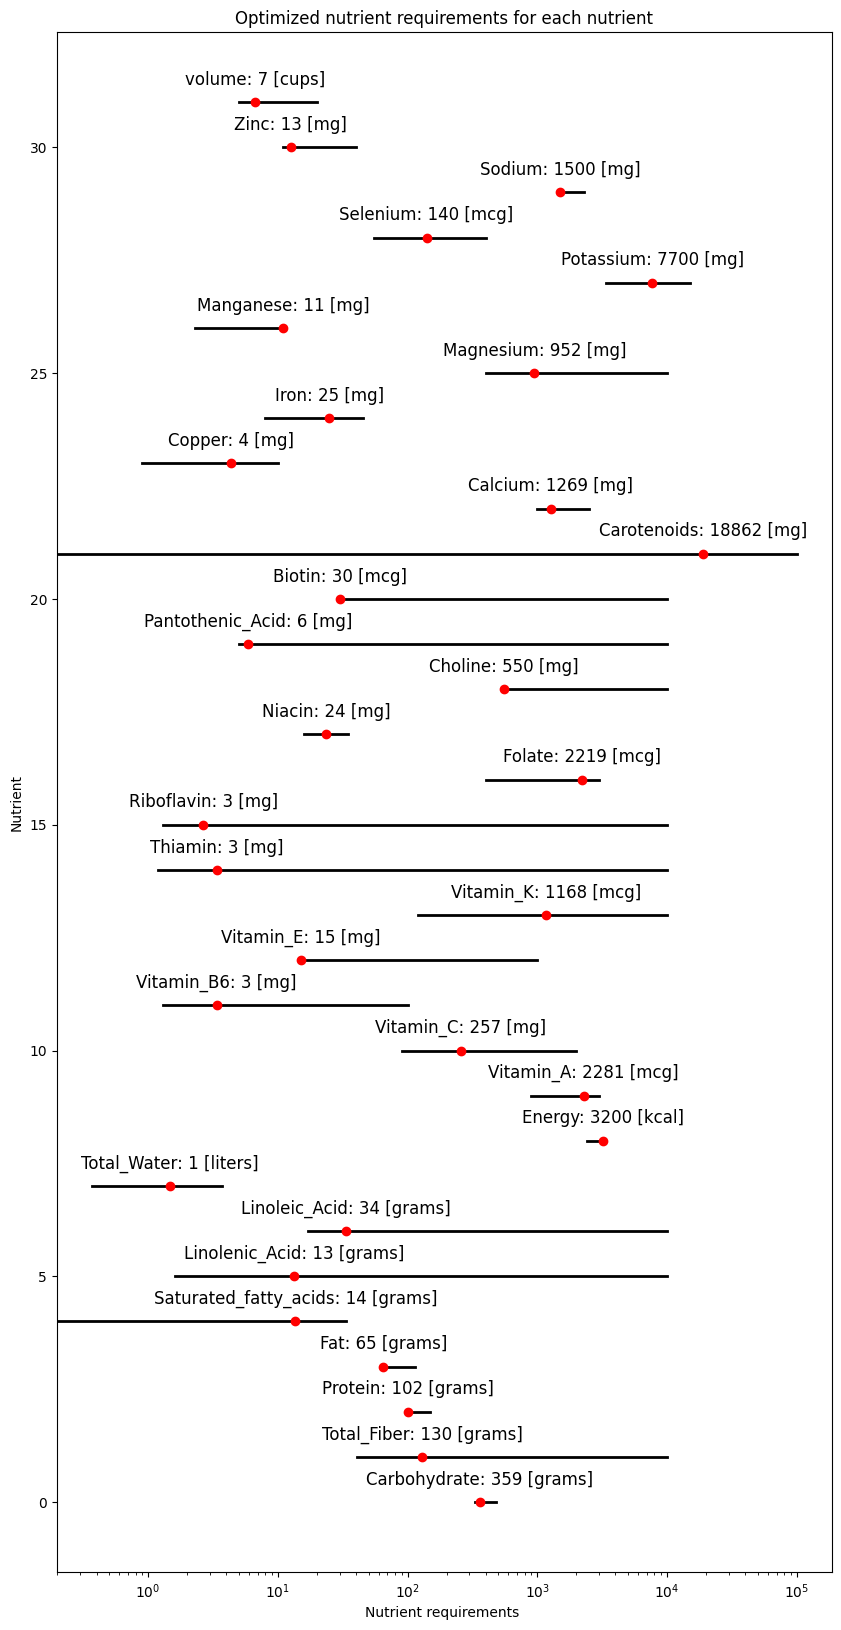

In [121]:
model.configuration.lp_method = "exact"
sol = model.optimize()
# pprint(constraints)
optimum_diet = {k:v for k,v in model.primal_values.items() if v>0}
pprint(optimum_diet)

# deduce the nutritional composition of the optimum diet
# optimum_nutrition = {}
# for food, amount in optimum_diet.items():

# for variable in model.variables:
#     print(f"Variable {variable.name} has {variable.primal} from {variable.lb}-{variable.ub}")
    # if variable.name == "volume": continue
    # if variable.primal < float(str(nutrition[variable.name.replace("_", ' ')]["low_bound"]).replace(",", '')):
    #     print(f"\tfails to meet the minimum {nutrition[variable.name.replace('_', ' ')]['low_bound']}")

print(model.objective.value)
constraint_values = {}
for constraint in model.constraints:
    constraint_values[constraint.name] = {"lb": constraint.lb, "val": constraint.primal, "ub": constraint.ub}
    print(f"Constraint {constraint.name} has {constraint.primal} from {constraint.lb}-{constraint.ub}")
    if constraint.name == "volume": continue
    if constraint.primal < float(str(nutrition[constraint.name.replace("_", ' ')]["low_bound"]).replace(",", '')):
        print(f"\tfails to meet the minimum {nutrition[constraint.name.replace('_', ' ')]['low_bound']}")
    # print()
    # print(f"   Primal Value (LHS): {constraint.expression}")
    # print(f"Dual Value (Shadow Price): ")

display(constraint_values)

# visualize the output values
from matplotlib import pyplot
from numpy import log

fig = pyplot.figure(figsize=(10, 20))
for y, (consName, content) in enumerate(constraint_values.items()):
    # start, mid, end = log(content["lb"]), log(content["val"]), log(content["ub"])
    start, mid, end = content["lb"], content["val"], content["ub"]
    end = 100000 if end == inf else end
    pyplot.plot([start, mid], [y,y], 'k-', linewidth=2)  # Lower segment
    pyplot.plot([mid, end], [y,y], 'k-', linewidth=2)  # Upper segment
    pyplot.scatter([mid], [y], color='red', zorder=3)  # Midpoint as a red dot
    if consName == "volume":  text = consName ; unit = "[cups]"
    else:  text = consName ; unit = f"[{nutrition[consName.replace('_', ' ')]['units']}]"
    # pyplot.text(start, y + 0.3, f"{round(start)} {unit}", fontsize=12, ha='center', va='bottom')
    pyplot.text(mid, y + 0.3, f"{text}: {round(mid)} {unit}", fontsize=12, ha='center', va='bottom')
    # pyplot.text(end, y + 0.3, f"{round(end)} {unit}", fontsize=12, ha='center', va='bottom')
pyplot.xscale("log")
pyplot.xlabel("Nutrient requirements ")
pyplot.ylabel("Nutrient")
pyplot.title("Optimized nutrient requirements for each nutrient")

pyplot.savefig("optimized_diet.png")